In [ ]:
import torch
import numpy as np
import torch.nn.functional as F
from torch import einsum
import einops
from tqdm.notebook import tqdm
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.6 MB/s eta 0:00:00


In [ ]:
def generate_sphere_data(n_points, d_sphere):
  """
  Generate a tensor of shape [n_points, d_sphere] where each row is a uniformly 
  random point on an n-sphere where n = d_sphere. 
  
  Each point on an n-sphere can be represented as an n-tuple (x1, x2 ... xn) 
  such that x1^2 + x2^2 + ... + xn^2 = r^2, where r is the sphere radius. In our
  case we're generating points on a unit sphere so r = 1.
  """
  feature_weights = torch.randn((d_sphere, n_points))
  # divide each point by its l2 norm so the point sits on a unit sphere
  l2_norm = torch.sum(feature_weights**2, axis=0)**(0.5)  # [n_points]
  x = feature_weights / l2_norm
  return x

In [ ]:
h = 64
G = 512

class Autoencoder(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = torch.nn.Linear(h, G)
    self.decoder = torch.nn.Linear(G, h, bias=False)

    torch.nn.init.orthogonal_(self.decoder.weight)


  def forward(self, x):
    hidden = F.relu(self.encoder(x))
    
    # each h dimension should sum to 1, we use an L2 norm to achieve this
    # print(self.decoder.weight.shape) # [h, G]
    l2_norm = torch.sum(self.decoder.weight**2, axis=0)**(0.5)  # [n_points]
    normalized_decoder_weights = self.decoder.weight / l2_norm
    x = hidden @ normalized_decoder_weights.T
    return (x, hidden)

In [ ]:
from torch.optim import lr_scheduler
model = Autoencoder()
model.to("cuda")

optim = torch.optim.Adam(model.parameters(), lr=0.001)

criterion = torch.nn.MSELoss()
# l1 = torch.nn.L1Loss()
alpha = 0.001

batch_size = 256
phi = 5

# Step 1: generate ground truth features
features = generate_sphere_data(G, h).to("cuda")

for i in tqdm(range(30000)):
  sparse_coefficients = torch.rand(batch_size, G) < (phi / G)
  sparse_coefficients = sparse_coefficients.to(torch.int)

  activations = torch.rand(batch_size, G)
  activated_coefficients = sparse_coefficients * activations
  activated_coefficients = activated_coefficients.to("cuda")

  superimposed_features = einsum("h g, b g -> b h", features, activated_coefficients)
  superimposed_features = superimposed_features.to(device="cuda")

  # Step 2: train
  optim.zero_grad()
  x, hidden = model(superimposed_features)

  #l1_loss = sum(1 / G * alpha * torch.linalg.vector_norm(hidden, dim=1, ord=1))
  l1_loss = (1/G)*alpha*torch.sum(torch.abs(hidden))
  crit_loss = criterion(x, superimposed_features)

  loss = crit_loss + l1_loss
  loss.backward()
  optim.step()

  if (i+1)%500 == 0:
    print(f"Batch {i+1}, criterion_loss={np.round(crit_loss.item(), 4)}, l1_loss={np.round(l1_loss.item(), 4)}")
    print((torch.sum(hidden > 0) / batch_size).item())

  0%|          | 0/30000 [00:00<?, ?it/s]

Batch 500, criterion_loss=0.0014, l1_loss=0.0033
151.35546875
Batch 1000, criterion_loss=0.0008, l1_loss=0.003
156.92578125
Batch 1500, criterion_loss=0.0006, l1_loss=0.0032
159.23046875
Batch 2000, criterion_loss=0.0004, l1_loss=0.0031
155.08984375
Batch 2500, criterion_loss=0.0004, l1_loss=0.0029
147.3984375
Batch 3000, criterion_loss=0.0004, l1_loss=0.0029
147.546875
Batch 3500, criterion_loss=0.0004, l1_loss=0.003
149.6015625
Batch 4000, criterion_loss=0.0004, l1_loss=0.003
147.640625
Batch 4500, criterion_loss=0.0004, l1_loss=0.0031
149.58984375
Batch 5000, criterion_loss=0.0004, l1_loss=0.0029
144.6015625
Batch 5500, criterion_loss=0.0004, l1_loss=0.003
146.73828125
Batch 6000, criterion_loss=0.0004, l1_loss=0.0028
142.30859375
Batch 6500, criterion_loss=0.0004, l1_loss=0.0029
145.71875
Batch 7000, criterion_loss=0.0004, l1_loss=0.0029
144.22265625
Batch 7500, criterion_loss=0.0004, l1_loss=0.0029
144.95703125
Batch 8000, criterion_loss=0.0004, l1_loss=0.0028
145.171875
Batch 850

In [ ]:
# Compute cosine similarity
dictionary = model.decoder.weight # .to("cpu") # [h, G]
cosine_sims = torch.zeros(G, G)

for i, feature in enumerate(features.T):
  for j, learned in enumerate(dictionary.T):
    cosine_sims[i][j] = F.cosine_similarity(feature, learned, dim=0)

max_cosine_sims = torch.max(cosine_sims, dim=1).values

mean_max_cosine_sim = torch.mean(max_cosine_sims)

print(mean_max_cosine_sim)

tensor(0.6078, grad_fn=<MeanBackward0>)


tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0594, 0.0000, 0.0095],
        [0.0000, 0.0000, 0.0000,  ..., 0.0538, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0035, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0251, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<SliceBackward0>)


<Axes: ylabel='Count'>

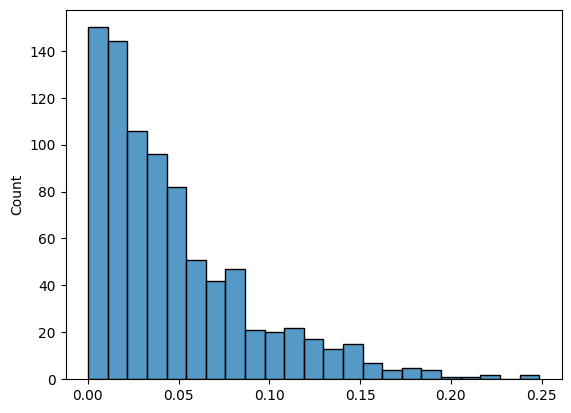

In [ ]:
# Check how model activations look like on a small batch
sparse_coefficients = torch.rand(5, G) < (phi / G)
sparse_coefficients = sparse_coefficients.to(torch.int).to("cuda")

activations = torch.rand(5, G).to("cuda")
activated_coefficients = sparse_coefficients * activations

# print("Nonzero active coefficients: ", activated_coefficients[activated_coefficients>0])

superimposed_features = einsum("h g, b g -> b h", features, activated_coefficients)
superimposed_features = superimposed_features.to(device="cuda")

x, hidden = model(superimposed_features)
print(hidden[:5])

hidden = hidden.flatten().cpu().detach().numpy()
sns.histplot(hidden[hidden > 0])

# print(x.shape, hidden.shape)
# print(hidden[hidden>0])

# print(torch.argwhere(hidden), torch.argwhere(activated_coefficients))

## Test cosine sim code

In [ ]:
# Easy to read alternative
dictionary = model.decoder.weight.to("cpu").detach()

max_cosine_sims = []
for feature_index in range(G):
  feature = features[:, feature_index]
  feature_cosine_sims = []
  for dict_index in range(G):
    learned_feature = dictionary[:, dict_index]
    cosine_sim = F.cosine_similarity(feature, learned_feature, dim=0)
    feature_cosine_sims.append(cosine_sim.item())
  max_cosine_sims.append(max(feature_cosine_sims))

print(max_cosine_sims[:5])
print(np.mean(max_cosine_sims))

[0.181926429271698, 0.2295827716588974, 0.2077474147081375, 0.19578766822814941, 0.15555953979492188]
0.1893892841762863


## Test data generation

<Axes: >

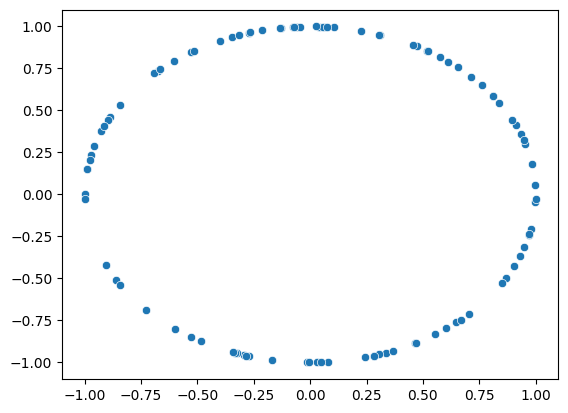

In [ ]:
# Plot new method
test_data = generate_sphere_data(100, 2)
sns.scatterplot(x=test_data[0, :], y=test_data[1, :])

<Axes: >

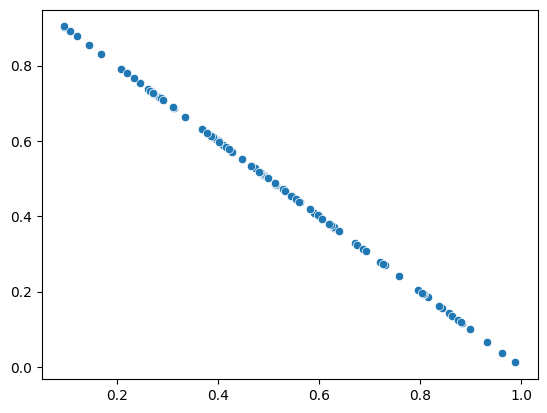

In [ ]:
# Plot old method
test_data = torch.rand(2, 100)
test_data = F.normalize(test_data, p=1, dim=0)
sns.scatterplot(x=test_data[0, :], y=test_data[1, :])